In [1]:
import os
import json
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tabulate import tabulate

import plot_helper as plot_helper

from dotenv import load_dotenv
load_dotenv()

streamer = os.environ.get("TWITCH_STREAMER")
with open(f"data/{streamer}.json") as f:
    predictionEvents = json.load(f)
predictionEvents.reverse()
print(streamer)


crazzyccat


In [2]:
myid = "257775320"

extracted_data = []
for predictionEvent in predictionEvents:
    title = predictionEvent["title"]
    date = predictionEvent["endedAt"]
    outcomes = predictionEvent["outcomes"]
    win_outcome = outcomes[0]
    los_outcome = outcomes[1]
    win_tp = win_outcome["totalPoints"]+1
    los_tp = los_outcome["totalPoints"]+1
    win_tu = win_outcome["totalUsers"]
    los_tu = los_outcome["totalUsers"]
    is_win = predictionEvent["winningOutcome"]["id"] == outcomes[0]["id"]
    prediction_window = predictionEvent["predictionWindowSeconds"]
    for predictor in win_outcome["topPredictors"]:
        predictor_bet = predictor["points"]
        predictor_payout = math.floor(predictor_bet * los_tp / win_tp)
        predictor_delta = predictor_payout if is_win else predictor_bet
        if not predictor["user"]: continue
        userid = predictor["user"]["id"]
        usernm = predictor["user"]["displayName"]
        if usernm == myid: los_tp -= predictor_bet
    for predictor in los_outcome["topPredictors"]:
        predictor_bet = predictor["points"]
        predictor_payout = math.floor(predictor_bet * win_tp / los_tp)
        predictor_delta = predictor_payout if not is_win else predictor_bet
        if not predictor["user"]: continue
        userid = predictor["user"]["id"]
        usernm = predictor["user"]["displayName"]
        if usernm == myid: los_tp -= predictor_bet

    if date < "2021-02-15T12:00":
        continue

    extracted_data.append((date, win_tp, los_tp, win_tp/(win_tp+los_tp), is_win))

df = pd.DataFrame.from_records(extracted_data, columns=["date", "win_tp", "los_tp", "wl_percent", "is_win"])
df


,date,win_tp,los_tp,wl_percent,is_win
0,2021-02-15T18:08:53.770217997Z,651179,470163,0.580714,False
1,2021-02-15T18:55:04.03619622Z,1914020,601171,0.760984,True
2,2021-02-15T19:48:03.071662311Z,711629,440581,0.617621,True
3,2021-02-15T20:42:18.531487277Z,329970,487013,0.403888,False
4,2021-02-15T21:10:30.111846457Z,769629,415868,0.649204,True
...,...,...,...,...,...
1317,2021-08-28T10:20:37.45842814Z,2826242,3407534,0.453376,False
1318,2021-08-28T11:10:18.70363926Z,3244505,3445470,0.484980,True
1319,2021-08-28T12:12:21.052589724Z,5205378,5300521,0.495472,False
1320,2021-09-03T22:19:49.707376719Z,851195,589302,0.590904,False


In [3]:
df.head()


,date,win_tp,los_tp,wl_percent,is_win
0,2021-02-15T18:08:53.770217997Z,651179,470163,0.580714,False
1,2021-02-15T18:55:04.03619622Z,1914020,601171,0.760984,True
2,2021-02-15T19:48:03.071662311Z,711629,440581,0.617621,True
3,2021-02-15T20:42:18.531487277Z,329970,487013,0.403888,False
4,2021-02-15T21:10:30.111846457Z,769629,415868,0.649204,True


In [4]:
df.describe()


,win_tp,los_tp,wl_percent
count,1.322000e+03,1.322000e+03,1322.000000
mean,5.222051e+05,4.139103e+05,0.560845
std,4.806260e+05,3.975622e+05,0.129994
min,2.581000e+03,5.106000e+03,0.020924
25%,2.715170e+05,1.895622e+05,0.485008
50%,4.293500e+05,3.312850e+05,0.556149
75%,6.516552e+05,5.151482e+05,0.639201
max,8.701442e+06,5.300521e+06,0.995449


In [5]:
import sklearn.linear_model as linear_model
from scipy.special import expit, logit

x = df['wl_percent'].to_numpy()
x = logit(x)
y = df['is_win'].to_numpy()
clf = linear_model.LogisticRegression()
clf.fit(x.reshape(-1, 1), y)
coeff = clf.coef_[0][0]
intcp = clf.intercept_[0]

print(coeff, intcp)


0.40039600416795007 -0.07513195424505913


Text(0.5, 1.0, 'histogram of x')

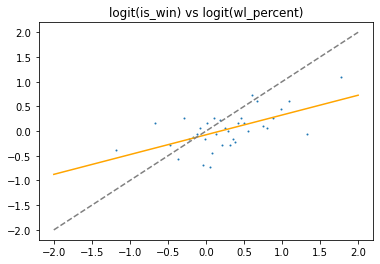

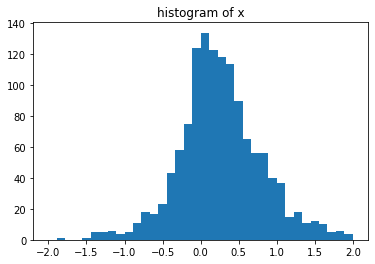

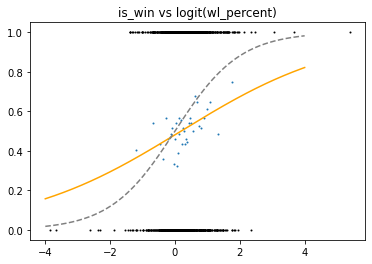

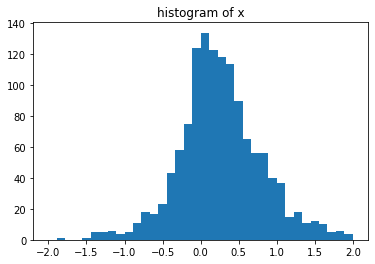

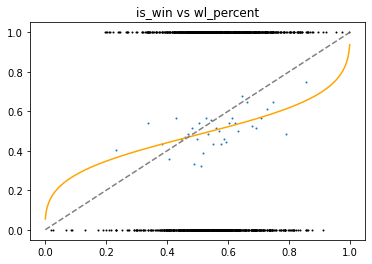

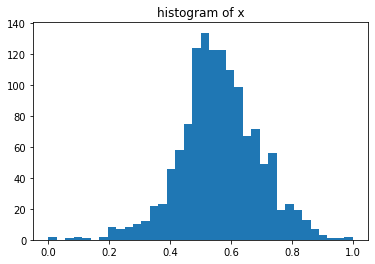

In [6]:
def generate_bins(x, y):
    bins_data = []
    bins = math.floor(math.sqrt(len(y)))
    for r in range(bins):
        rlower = r*100/bins
        rupper = (r+1)*100/bins
        rmiddl = (rupper+rlower)/2
        xlower = np.percentile(x, rlower)
        xupper = np.percentile(x, rupper)
        xmiddl = np.percentile(x, rmiddl)
        x_interval = (xlower <= x) & (x < xupper)
        win = np.sum(x_interval * y)
        los = np.sum(x_interval * (1-y))
        bins_data.append([rlower, rmiddl, rupper, xlower, xmiddl, xupper, win+los, win/(win+los)])
    xbins = [e[4] for e in bins_data]
    ybins = [e[7] for e in bins_data]
    return xbins, ybins

x = df['wl_percent'].to_numpy()
x = logit(x)
y = df['is_win'].to_numpy()
xbins, ybins = generate_bins(x, y)
ybins = logit(ybins)
x_test_log = np.linspace(-2, 2, 401)
loss = x_test_log * coeff + intcp
plt.figure()
plt.scatter(xbins, ybins, s=1)
plt.plot(x_test_log, loss, color='orange')
plt.plot(x_test_log, x_test_log, color='.5', linestyle='dashed')
plt.title("logit(is_win) vs logit(wl_percent)")
plt.figure()
plt.hist(x, range=(-2,2), bins=len(xbins))
plt.title("histogram of x")

x = df['wl_percent'].to_numpy()
x = logit(x)
y = df['is_win'].to_numpy()
xbins, ybins = generate_bins(x, y)
x_test_log = np.linspace(-4, 4, 401)
loss = expit(x_test_log * coeff + intcp)
plt.figure()
plt.scatter(x, y, color='black', s=1)
plt.scatter(xbins, ybins, s=1)
plt.plot(x_test_log, loss, color='orange')
plt.plot(x_test_log, expit(x_test_log), color='.5', linestyle='dashed')
plt.title("is_win vs logit(wl_percent)")
plt.figure()
plt.hist(x, range=(-2,2), bins=len(xbins))
plt.title("histogram of x")

x = df['wl_percent'].to_numpy()
y = df['is_win'].to_numpy()
xbins, ybins = generate_bins(x, y)
x_test = np.linspace(0.001, 0.999, 401)
loss = expit(logit(x_test) * coeff + intcp)
plt.figure()
plt.scatter(x, y, color='black', s=1)
plt.scatter(xbins, ybins, s=1)
plt.plot(x_test, loss, color='orange')
plt.plot(x_test, x_test, color='.5', linestyle='dashed')
plt.title("is_win vs wl_percent")
plt.figure()
plt.hist(x, range=(0,1), bins=len(xbins))
plt.title("histogram of x")


In [7]:
win_tp_numpy = df['win_tp'].to_numpy()
los_tp_numpy = df['los_tp'].to_numpy()
sum_tp_numpy = win_tp_numpy + los_tp_numpy
wl_percent_numpy = df['wl_percent'].to_numpy()
is_win_numpy = df['is_win'].to_numpy()

def run_simulation(multi, maxbt, maxtt):
    p_estimate = np.clip(expit(logit(wl_percent_numpy)*coeff+intcp), 0.01, 0.99)
    bet_on_win = wl_percent_numpy <= p_estimate
    bet_amount = win_tp_numpy*los_tp_numpy*np.where(bet_on_win, p_estimate/(1-p_estimate), (1-p_estimate)/p_estimate)
    bet_amount = np.sqrt(bet_amount)-np.where(bet_on_win, win_tp_numpy, los_tp_numpy)
    bet_amount *= multi
    bet_amount = np.clip(bet_amount, 0, maxbt)
    bet_amount = np.clip(bet_amount, 0, (sum_tp_numpy<maxtt)*250000)
    bet_amount = np.clip(bet_amount, 0, 250000)
    gain = -bet_amount
    gain = np.where(is_win_numpy&bet_on_win, bet_amount*los_tp_numpy/(win_tp_numpy+bet_amount), gain)
    gain = np.where(~is_win_numpy&~bet_on_win, bet_amount*win_tp_numpy/(los_tp_numpy+bet_amount), gain)

    data = []
    acc = 0
    for date, g in zip(df['date'].to_list(), gain):
        data.append((date, acc))
        acc += g
        data.append((date, acc))
    cumu = np.cumsum(gain)
    cumu_max = np.maximum.accumulate(cumu)
    unluckiest = np.amax(cumu_max-cumu)
    return data, gain, unluckiest

def run_simulation_gain_only(multi, maxbt, maxtt):
    p_estimate = np.clip(expit(logit(wl_percent_numpy)*coeff+intcp), 0.01, 0.99)
    bet_on_win = wl_percent_numpy <= p_estimate
    bet_amount = win_tp_numpy*los_tp_numpy*np.where(bet_on_win, p_estimate/(1-p_estimate), (1-p_estimate)/p_estimate)
    bet_amount = np.sqrt(bet_amount)-np.where(bet_on_win, win_tp_numpy, los_tp_numpy)
    bet_amount *= multi
    bet_amount = np.clip(bet_amount, 0, maxbt)
    bet_amount = np.clip(bet_amount, 0, (sum_tp_numpy<maxtt)*250000)
    bet_amount = np.clip(bet_amount, 0, 250000)
    gain = -bet_amount
    gain = np.where(is_win_numpy&bet_on_win, bet_amount*los_tp_numpy/(win_tp_numpy+bet_amount), gain)
    gain = np.where(~is_win_numpy&~bet_on_win, bet_amount*win_tp_numpy/(los_tp_numpy+bet_amount), gain)
    cumu = np.cumsum(gain)
    cumu_max = np.maximum.accumulate(cumu)
    unluckiest = np.amax(cumu_max-cumu)
    return (unluckiest<700000)*np.sum(gain) * (1-0.01*abs(multi-1.25)/0.75-0.01*abs(maxbt-125000)/125000-0.01*abs(maxtt-1600000)/1600000)


[0.7487030020946611, 76605.63460252194, 1565852.283474926, 0.40039600416795007, -0.07513195424505913]; // 9984306-698300=9876786


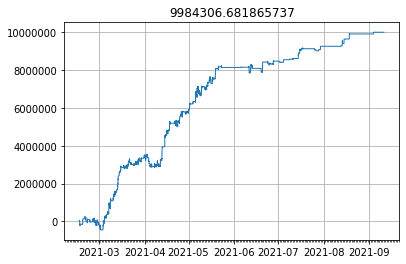

In [8]:
import scipy.optimize as optimize

def objective(x):
    return -run_simulation_gain_only(*x)

bounds = [
    (0.5, 2.0),
    (0, 250000),
    (0, np.amax(sum_tp_numpy)),
]
result = optimize.differential_evolution(objective, bounds)
data, gain, unluckiest = run_simulation(*result.x)
plot_helper.plot_datetimes_vs_value(data, xlim=False, title=True)
print(f"{str([*result.x, coeff, intcp])}; // {int(np.sum(gain))}-{int(unluckiest)}={int(-result.fun)}")


[1.5, 40000, 1600000, 0.40039600416795007, -0.07513195424505913]; // 8360881-598551=9876786


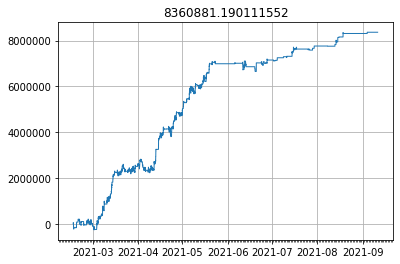

In [9]:
result.x = [1.5, 40000, 1600000]
data, gain, unluckiest = run_simulation(*result.x)
plot_helper.plot_datetimes_vs_value(data, xlim=False, title=True)
print(f"{str([*result.x, coeff, intcp])}; // {int(np.sum(gain))}-{int(unluckiest)}={int(-result.fun)}")
